In [1]:
import scipy.stats as ss

In [2]:
%matplotlib inline

## Example with n x 1 data

In [23]:
np.random.random((10000,5))

array([[ 0.71705892,  0.14338901,  0.55216855,  0.16642784,  0.27656289],
       [ 0.10572914,  0.49014827,  0.56487726,  0.14602259,  0.14897216],
       [ 0.80110396,  0.39537675,  0.12272142,  0.39572787,  0.20174706],
       ..., 
       [ 0.79984014,  0.99240982,  0.42382351,  0.23441801,  0.70807181],
       [ 0.41059782,  0.45930933,  0.25596535,  0.23151271,  0.71220148],
       [ 0.23132378,  0.75998546,  0.75783796,  0.56483733,  0.43935977]])

In [24]:
f = h5py.File('/tmp/blah.h5', 'w')

d = f.create_dataset('chr1', (10000,5), compression='gzip')
d[:] = np.random.random((10000,5))
f.close()

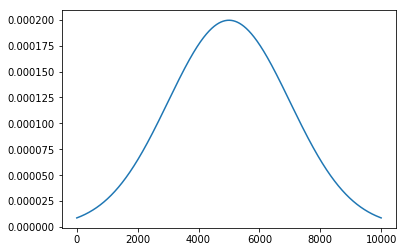

In [59]:
## create some input data
import matplotlib.pyplot as plt
import scipy.stats as ss

array_length = 10000

xs = range(array_length)
array_data = [ss.norm.pdf(i, array_length/2, array_length/5) for i in xs]
plt.plot(xs, array_data)

In [277]:
import h5py 
import math
import os
import os.path as op
import numpy as np

def create_multires(array_data, chromsizes, 
                    agg, starting_resolution=1,
                    tile_size=1024, output_file='/tmp/my_file.multires'):
    '''
    Create a multires file containing the array data
    aggregated at multiple resolutions.
    
    Parameters
    ----------
    array_data: {'chrom_key': np.array, }
        The array data to aggregate organized by chromosome
    chromsizes: [('chrom_key', size),...]
    agg: lambda
        The function that will aggregate the data. Should
        take an array as input and create another array of
        roughly half the length
    starting_resolution: int (default 1)
        The starting resolution of the input data
    tile_size: int
        The tile size that we want higlass to use. This should
        depend on the size of the data but when in doubt, just use
        256.
    '''
    filename = output_file

    # this is just so we can run this code
    # multiple times without h5py complaining
    if op.exists(filename):
        os.remove(filename)

    # this will be the file that contains our multires data
    f = h5py.File(filename, 'w')
        
    # store some metadata
    f.create_group('info')
    f['info'].attrs['tile-size'] = tile_size
    
    f.create_group('resolutions')
    f.create_group('chroms')

    # start with a resolution of 1 element per pixel
    curr_resolution = starting_resolution

    # this will be our sample highest-resolution array
    # and it will be stored under the resolutions['1']
    # dataset
    f['resolutions'].create_group(str(curr_resolution))

    chroms = [c[0] for c in chromsizes]
    lengths = np.array([c[1] for c in chromsizes])
    chrom_array = np.array(chroms, dtype='S')
    
    # add the chromosome information
    f['resolutions'][str(curr_resolution)].create_group('chroms')
    f['resolutions'][str(curr_resolution)].create_group('values')
    f['resolutions'][str(curr_resolution)]['chroms'].create_dataset('name', shape=(len(chroms),), dtype=chrom_array.dtype, data=chrom_array)
    f['resolutions'][str(curr_resolution)]['chroms'].create_dataset('length', shape=(len(chroms),), data=lengths)

    f['chroms'].create_dataset('name', shape=(len(chroms),), dtype=chrom_array.dtype, data=chrom_array)
    f['chroms'].create_dataset('length', shape=(len(chroms),), data=lengths)

    # add the data
    for chrom,length in chromsizes:
        f['resolutions'][str(curr_resolution)]['values'].create_dataset(str(chrom), array_data[chrom].shape)
        print("array_data.shape", array_data[chrom].shape)
        f['resolutions'][str(curr_resolution)]['values'][chrom][:] = array_data[chrom]    # see above section
        

    # the maximum zoom level corresponds to the number of aggregations
    # that need to be performed so that the entire extent of
    # the dataset fits into one tile
    total_length = sum([c[1] for c in chromsizes])
    max_zoom = math.ceil(math.log(total_length / (tile_size * starting_resolution) ) / math.log(2))
    print("max_zoom:", max_zoom)
    
    # we're going to go through and create the data for the different
    # zoom levels by summing adjacent data points
    prev_resolution = curr_resolution

    for i in range(max_zoom):
        # each subsequent zoom level will have half as much data
        # as the previous
        curr_resolution = prev_resolution * 2
        f['resolutions'].create_group(str(curr_resolution))
        f['resolutions'][str(curr_resolution)].create_group('chroms')
        f['resolutions'][str(curr_resolution)].create_group('values')
        f['resolutions'][str(curr_resolution)]['chroms'].create_dataset('name', shape=(len(chroms),), dtype=chrom_array.dtype, data=chrom_array)
        f['resolutions'][str(curr_resolution)]['chroms'].create_dataset('length', shape=(len(chroms),), data=lengths)


        for chrom,length in chromsizes:
            next_level_length = math.ceil(
                len(f['resolutions'][str(prev_resolution)]['values'][chrom]) / 2)

            old_data = f['resolutions'][str(prev_resolution)]['values'][chrom][:]
            #print("prev_resolution:", prev_resolution)
            #print("old_data.shape", old_data.shape)

            # this is a sort of roundabout way of calculating the 
            # shape of the aggregated array, but all its doing is
            # just halving the first dimension of the previous shape
            # without taking into account the other dimensions
            new_shape = list(old_data.shape)
            new_shape[0] = math.ceil(new_shape[0] / 2)
            new_shape = tuple(new_shape)

            f['resolutions'][str(curr_resolution)]['values'].create_dataset(chrom, 
                                            new_shape)

            #print("11 old_data.shape", old_data.shape)
            if len(old_data) % 2 != 0:
                # we need our array to have an even number of elements
                # so we just add the last element again
                old_data = np.concatenate((old_data, [old_data[-1]]))
            #print("22 old_data.shape", old_data.shape)

            #print('old_data:', old_data)
            #print("shape:", old_data.shape)
            # actually sum the adjacent elements
            #print("old_data.shape", old_data.shape)
            new_data = agg(old_data)

            '''
            print("zoom_level:", max_zoom - 1 - i, 
                  "resolution:", curr_resolution, 
                  "new_data length", len(new_data))
            '''
            f['resolutions'][str(curr_resolution)]['values'][chrom][:] = new_data

        prev_resolution = curr_resolution
    return f

chromsizes = [('a', 10), ('b', 8), ('c', 5)]
counter = 0
chrom_data = {}

for chrom,length in chromsizes:
    array_data = counter + np.array(range(length))
    array_length = len(array_data)
    #chrom_data[chrom] = np.array([array_data, array_data * 2]).T
    chrom_data[chrom] = array_data
    counter += array_length

    
chrom_lengths = [c[1] for c in chromsizes]

f = create_multires(chrom_data, 
                    chromsizes,
                    lambda x: x.T.reshape((-1,2)).sum(axis=1).T,
                    #lambda x: x.T.reshape((x.shape[1],-1,2)).sum(axis=2).T,
                   tile_size=2)

print(f['resolutions']['1']['values']['a'][:])
print(f['resolutions']['2']['values']['a'][:])
print(f['resolutions']['4']['values']['a'][:])

array_data.shape (10,)
array_data.shape (8,)
array_data.shape (5,)
max_zoom: 4
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
[  1.   5.   9.  13.  17.]
[  6.  22.  34.]


In [186]:
def abs2genomic(chromsizes, start_pos, end_pos):
    '''
    Convert absolute genomic sizes to genomic
    
    Parameters:
    -----------
    chromsizes: [1000,...]
        An array of the lengths of the chromosomes
    start_pos: int
        The starting genomic position
    end_pos: int
        The ending genomic position
    '''
    abs_chrom_offsets = np.r_[0, np.cumsum(chromsizes)]
    cid_lo, cid_hi = np.searchsorted(abs_chrom_offsets,
                                   [start_pos, end_pos],
                                   side='right') - 1
    rel_pos_lo = start_pos - abs_chrom_offsets[cid_lo]
    rel_pos_hi = end_pos - abs_chrom_offsets[cid_hi]
    start = rel_pos_lo
    for cid in range(cid_lo, cid_hi):
      yield cid, start, chromsizes[cid]
      start = 0
    yield cid_hi, start, rel_pos_hi

In [190]:
def get_tileset_info(f):
    '''
    Return some information about this tileset that will
    help render it in on the client.
    
    Parameters
    ----------
    f: h5py.File
        The f for which we're returning tileset info
    
    Returns
    -------
    tileset_info: {}
        A dictionary containing the information describing
        this dataset
    '''
    # a sorted list of resolutions, lowest to highest
    # awkward to write because a the numbers representing resolution
    # are datapoints / pixel so lower resolution is actually a higher
    # number
    resolutions = sorted([int(r) for r in f['resolutions'].keys()])[::-1]
    
    # the "leftmost" datapoint position
    # an array because higlass can display multi-dimensional
    # data
    min_pos = [0]
    
    # the "rightmost" datapoint position
    max_pos = [len(f['resolutions'][str(resolutions[-1])])]
    tile_size = f['info'].attrs['tile-size']
    
    return {
        'resolutions': resolutions,
        'min_pos': min_pos, 
        'tile_size': tile_size
    }

In [191]:
print(get_tileset_info(f))

{'resolutions': [16, 8, 4, 2, 1], 'min_pos': [0], 'tile_size': 2}


In [201]:
def get_tile(vals, chromsizes, resolution, start_pos, end_pos):
    '''
    Get the tile value given the start and end positions and
    chromosome positions. 
    
    Drop bins at the ends of chromosomes if those bins aren't
    full.
    
    Parameters:
    -----------
    vals: [...]
        An array of values for each bin along the genome
    chromsizes: [int]
        The sizes of the chromosomes in the order in which
        they should be displayed.
    resolution: int
        The size of each bin, except for the last bin in each
        chromosome.
    start_pos: int
        The start_position of the interval to return
    end_pos: int
        The end position of the interval to return
        
    Returns
    -------
    return_vals: [...]
        A subset of the original genome-wide values containing
        the values for the portion of the genome that is visible.
    '''
    binsize = resolution

    arrays = []
    for cid, start, end in abs2genomic([c[1] for c in chromsizes], start_pos, end_pos):
        n_bins = int(np.ceil((end - start) / binsize))
        print("cid:", cid, 'n_bins:', n_bins)
        
        try:
            chrom = chromsizes[cid][0]
            clen = chromsizes[cid][1]

            start_pos = start // binsize
            end_pos = end // binsize + 1
            
            x = f['resolutions'][str(resolution)]['values'][chrom][start_pos:end_pos]
            print("x:", x)

            # drop the very last bin if it is smaller than the binsize
            if len(x) > 1 and end == clen and clen % binsize != 0:
                print("dropping")
                x = x[:-1]
        except IndexError:
            # beyond the range of the available chromosomes
            # probably means we've requested a range of absolute
            # coordinates that stretch beyond the end of the genome
            x = np.zeros(n_bins)

        arrays.append(x)

    return np.concatenate(arrays)

get_tile(f, chromsizes, 4, 0, 23)

cid: 0 n_bins: 3
x: [  6.  22.  34.]
dropping
cid: 1 n_bins: 2
x: [ 46.  62.]
cid: 2 n_bins: 2
x: [ 78.  88.]
dropping
cid: 3 n_bins: 0


array([  6.,  22.,  46.,  62.,  78.])

In [5]:
def load_chromsizes(chromInfoFile):
    '''
    Load a set of chromosome sizes from a file. They should
    be of the format:
    
    chr \t size
    '''
    with open(chromInfoFile, 'r') as f1:
        chroms = []
        lengths = []
        for line in f1:
            parts = line.strip().split('\t')

            #print(parts)
            chroms += [parts[0]]
            lengths += [int(parts[1])]

        chromsizes = list(zip(chroms, lengths))
        return chromsizes

## Re-create our multi-vec data with chromosome names

In [12]:
import h5py
import math
import numpy as np
import os
import os.path as op

chromInfoFile = op.expanduser('~/projects/negspy/negspy/data/hg38/chromInfo.txt')
filename = op.expanduser('~/Dropbox/paper-data/meyer-data/my_file_genome_wide_hg38_v2.multires')
out_file = op.splitext(filename)[0] + ".multivec"

f_in = h5py.File(filename, 'r')

if op.exists(out_file):
    os.remove(out_file)

f_out = h5py.File(out_file, 'w')

chromsizes = load_chromsizes(chromInfoFile)
data_positions = np.r_[0, np.cumsum([c[1] for c in chromsizes])]
data_positions = np.array([math.ceil(d / 1000) for d in data_positions])
print('dp', len(data_positions))

print('chromsizes', [c[0] for c in chromsizes[:24]])
print('data_positions', data_positions[-1])
print('len', len(f_in['resolutions']['1000']))

count = 0
for i,(chrom,length) in enumerate(chromsizes[:24]):
    shape = f_in['resolutions']['1000'].shape
    data_length = math.ceil(length / 1000)
    print("chrom:", chrom, "data_length:", data_length)
    print("shape:", shape)

    f_out.create_dataset(chrom, (data_length,shape[1]), compression='gzip')
    f_out[chrom][:] = f_in['resolutions']['1000'][count:count+data_length]
    count += data_length
f_out.close()

dp 456
chromsizes ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY']
data_positions 3209287
len 3209513
chrom: chr1 data_length: 248957
shape: (3209513, 250)
chrom: chr2 data_length: 242194
shape: (3209513, 250)
chrom: chr3 data_length: 198296
shape: (3209513, 250)
chrom: chr4 data_length: 190215
shape: (3209513, 250)
chrom: chr5 data_length: 181539
shape: (3209513, 250)
chrom: chr6 data_length: 170806
shape: (3209513, 250)
chrom: chr7 data_length: 159346
shape: (3209513, 250)
chrom: chr8 data_length: 145139
shape: (3209513, 250)
chrom: chr9 data_length: 138395
shape: (3209513, 250)
chrom: chr10 data_length: 133798
shape: (3209513, 250)
chrom: chr11 data_length: 135087
shape: (3209513, 250)
chrom: chr12 data_length: 133276
shape: (3209513, 250)
chrom: chr13 data_length: 114365
shape: (3209513, 250)
chrom: chr14 data_length: 107044
sh

In [43]:
import pandas as pd

def add_row_infos(filename, row_infos_filename, force=False):
    '''
    Add row information to an HDF5 file
    
    Parameters
    ----------
    filename: h5py.File
        An input hdf5 file containing the multivec data
    row_info_file: string
        The filename of the file containing the row information
    '''
    f_h5 = h5py.File(filename, 'r+')

    with open(row_infos_filename, 'r') as f:
        row_infos = [l.strip().encode('utf8') for l in f.readlines()]
        
    if 'row_infos' in f_h5.attrs:
        if not force:
            print("row_infos already exist, use --force to override")
            return
        else:
            # delete the existing sample infos so that we can replace them with others
            del f_h5.attrs['row_infos']

    f_h5.attrs.create('row_infos', row_infos)
    
    #f_h5.attrs['row_infos'] = row_infos
    #print("row_infos", row_infos)
    f_h5.close()
    
    
row_infos_filename = '/Users/peter/Dropbox/paper-data/meyer-data/sample_info.txt'
filename = '/Users/peter/Dropbox/paper-data/meyer-data/my_file_genome_wide_hg38_v2.multivec'

add_row_infos(filename, row_infos_filename, force=True)

In [2]:
import h5py

filename = '/Users/peter/Dropbox/paper-data/meyer-data/my_file_genome_wide_hg38_v2.multivec'

print("filename:", filename)
f = h5py.File(filename, 'r')
print("f.attrs", list(f.attrs.keys()))
print("f.attrs[row_infos]", f.attrs['row_infos'][:])
f.close()

filename: /Users/peter/Dropbox/paper-data/meyer-data/my_file_genome_wide_hg38_v2.multivec
f.attrs ['sample_infos', 'row_infos']
f.attrs[row_infos] [ b'Homo sapiens\tHCT116-H3K27AC\tGSM1415876\tGSE58638\tHCT-116\tEpithelium\tColon\tanti-H3K27ac (Active Motif #39135)\tH3K27ac\thm\tNone'
 b'Homo sapiens\tDKO1-H3K27AC\tGSM1415884\tGSE58638\tDKO1\tNone\tNone\tanti-H3K27ac (Active Motif #39135)\tH3K27ac\thm\tNone'
 b'Homo sapiens\tENCODE3_H3K27ac\tENCSR435JKM_1\tENCSR435JKM\tA549\tEpithelium\tNone\tNone\tH3K27ac\thm\tNone'
 b'Homo sapiens\tBLUEPRINT_S00COJH1_H3K27AC\tGSM1406317\tGSE58310\tNone\tMacrophage\tBlood\tNone\tH3K27ac\thm\tNone'
 b'Homo sapiens\tIFTSEC33_H3K27AC_NA_REP2_1\tGSM1663027\tGSE68104\tFT33\tEpithelium\tFallopian tube secretory\tH3K27AC (ABCAM AB4729)\tH3K27ac\thm\tNone'
 b'Homo sapiens\tPFEIFFER H3K27AC\tGSM1703923\tGSE69558\tPfeiffer\tB Lymphocyte\tLymph Node\tH3K27ac (39133, Active Motif)\tH3K27ac\thm\tNone'
 b'Homo sapiens\tTOLEDO H3K27AC\tGSM1703931\tGSE69558\tToledo\t

In [268]:
f_out['chr1'][:].shape

ValueError: Not a location (Invalid object id)

In [243]:
print(chromsizes[:24])

[('chr1', 248956422), ('chr2', 242193529), ('chr3', 198295559), ('chr4', 190214555), ('chr5', 181538259), ('chr6', 170805979), ('chr7', 159345973), ('chr8', 145138636), ('chr9', 138394717), ('chr10', 133797422), ('chr11', 135086622), ('chr12', 133275309), ('chr13', 114364328), ('chr14', 107043718), ('chr15', 101991189), ('chr16', 90338345), ('chr17', 83257441), ('chr18', 80373285), ('chr19', 58617616), ('chr20', 64444167), ('chr21', 46709983), ('chr22', 50818468), ('chrX', 156040895), ('chrY', 57227415), ('chrM', 16569)]


In [278]:
%%time 

chromInfoFile = ('/Users/pete/projects/negspy/negspy/data/hg38/chromInfo.txt')
chromsizes = load_chromsizes(chromInfoFile)
out_file = '/tmp/hg38.multires'
f_out = h5py.File(out_file, 'r')

out_file = '/tmp/hg38.tiled.multires'

f_multi = create_multires(f_out, 
                    chromsizes[:24],
                    lambda x: x.T.reshape((x.shape[1],-1,2)).sum(axis=2).T,
                    tile_size=256,
                    starting_resolution=1000,
                    output_file=out_file)

array_data.shape (248957, 256)
array_data.shape (242194, 256)
array_data.shape (198296, 256)
array_data.shape (190215, 256)
array_data.shape (181539, 256)
array_data.shape (170806, 256)
array_data.shape (159346, 256)
array_data.shape (145139, 256)
array_data.shape (138395, 256)
array_data.shape (133798, 256)
array_data.shape (135087, 256)
array_data.shape (133276, 256)
array_data.shape (114365, 256)
array_data.shape (107044, 256)
array_data.shape (101992, 256)
array_data.shape (90339, 256)
array_data.shape (83258, 256)
array_data.shape (80374, 256)
array_data.shape (58618, 256)
array_data.shape (64445, 256)
array_data.shape (46710, 256)
array_data.shape (50819, 256)
array_data.shape (156041, 256)
array_data.shape (57228, 256)
max_zoom: 14
CPU times: user 3.54 s, sys: 17.4 s, total: 21 s
Wall time: 35.9 s


In [279]:
f_multi.keys()
f_multi.close()

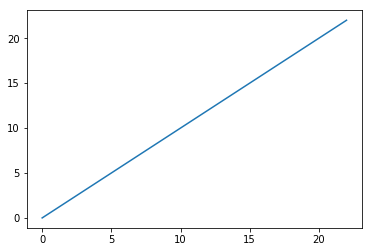

In [117]:
# the largest tile (zoom level 0, position 0) contains a downsampled
# version of the entire dataset
d = get_tile(f, [0,0])
plt.plot(d)

In [118]:
# going to the first tile of the next zoom level
# we're showing less data
d = get_tile(f, [1,0])
plt.plot(d)

IndexError: list index out of range

In [119]:
# the second tile of zoom_level 1 contains the
# data to the "right" of the first tile
d = get_tile(f, [1,1])
plt.plot(d)

IndexError: list index out of range

## Example with n x c data

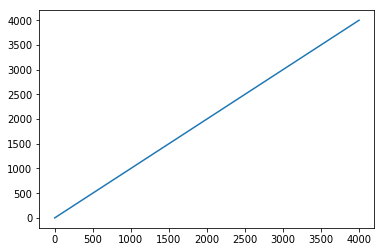

In [120]:
## create some input data
import h5py 
import math
import os
import os.path as op
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as ss

array_length = 4000
array_width = 5

xs = range(array_length)
array_data = np.array([i * np.array(range(array_length))
              for i in range(1,array_width+1)]).T
plt.plot(xs, array_data[:,0])

In [121]:
array_data

array([[    0,     0,     0,     0,     0],
       [    1,     2,     3,     4,     5],
       [    2,     4,     6,     8,    10],
       ..., 
       [ 3997,  7994, 11991, 15988, 19985],
       [ 3998,  7996, 11994, 15992, 19990],
       [ 3999,  7998, 11997, 15996, 19995]])

In [122]:
array_data.T.reshape((array_data.shape[1],-1,2)).sum(axis=2).T

array([[    1,     2,     3,     4,     5],
       [    5,    10,    15,    20,    25],
       [    9,    18,    27,    36,    45],
       ..., 
       [ 7989, 15978, 23967, 31956, 39945],
       [ 7993, 15986, 23979, 31972, 39965],
       [ 7997, 15994, 23991, 31988, 39985]])

In [123]:
f = create_multires(np.array(array_data), 
                    array_length,
                    lambda x: x.T.reshape((x.shape[1],-1,2)).sum(axis=2).T)

max_zoom: 2
zoom_level: 1 resolution: 2 new_data length 2000
zoom_level: 0 resolution: 4 new_data length 1000


In [124]:
print(get_tileset_info(f))

{'resolutions': [4, 2, 1], 'min_pos': [0], 'tile_size': 1024}


In [125]:
get_tile(f, [0,0])

array([[  6.00000000e+00,   1.20000000e+01,   1.80000000e+01,
          2.40000000e+01,   3.00000000e+01],
       [  2.20000000e+01,   4.40000000e+01,   6.60000000e+01,
          8.80000000e+01,   1.10000000e+02],
       [  3.80000000e+01,   7.60000000e+01,   1.14000000e+02,
          1.52000000e+02,   1.90000000e+02],
       ..., 
       [  1.59580000e+04,   3.19160000e+04,   4.78740000e+04,
          6.38320000e+04,   7.97900000e+04],
       [  1.59740000e+04,   3.19480000e+04,   4.79220000e+04,
          6.38960000e+04,   7.98700000e+04],
       [  1.59900000e+04,   3.19800000e+04,   4.79700000e+04,
          6.39600000e+04,   7.99500000e+04]], dtype=float32)

## Adding chromosome info to the resulting file



In [127]:
#filename = '/tmp/my_file.multires'
#filename = '/Users/pete/projects/higlass-server/media/uploads/my_file_genome_wide_hg38.multires'
#chromInfoFile = ('/Users/pete/projects/negspy/negspy/data/hg38/chromInfo.txt')



In [128]:
print('chromsizes', chromsizes[:10])

chromsizes [('chr1', 248956422), ('chr2', 242193529), ('chr3', 198295559), ('chr4', 190214555), ('chr5', 181538259), ('chr6', 170805979), ('chr7', 159345973), ('chr8', 145138636), ('chr9', 138394717), ('chr10', 133797422)]


In [2]:
import h5py
f = h5py.File('/tmp/blah.h5', 'w')
f.create_group('chr1')

<HDF5 group "/chr1" (0 members)>